In [1]:
import torch
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline
from a2c.model import Policy
from microgrid import MG_for_test

In [2]:
env = MG_for_test(True,True)
actor_critic = Policy(
    env.observation_space.shape,
    env.action_space.shape,
    base_kwargs={'recurrent': True,'assign_credit':True})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_critic.to(device)
#policy = A2C(args, net, optimizer, device)
checkpoint = torch.load('./models/multi_values/best')
actor_critic.base.load_state_dict(checkpoint['model_state_dict'],strict=False)
actor_critic.base.eval()

Network(
  (gru): GRU(20, 128)
  (actor): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
  )
  (mean): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (std): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (critic): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [3]:
from evaluation_test import evaluate
env_settings ={'assign_credit':True, 'privacy_preserving':True, 'compared':False}
consumption,loss = evaluate(actor_critic, 9, 8, device, env_settings)
print(consumption)
print(loss)


local connection 64 is closed
local connection 70 is closed
local connection 74 is closed
local connection 63 is closed
local connection 65 is closed
local connection 68 is closed
local connection 72 is closed

local connection 62 is closed






31.68553666951899
14.92075597816355


In [3]:
observations = np.zeros([12*24,env.observation_space.shape[0]])
T_AC = np.zeros([12*24,10])
E_EV = np.zeros([12*24,5])
costs = np.zeros([12*24,16])
P_AC = np.zeros([12*24,10])
env.seed(1)
obs = env.reset()
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=0
while done == False:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, info = env.move(action.detach().cpu().numpy()[0])
    observations[i] = obs
    T_AC[i] = env.ACs_T
    E_EV[i] = env.EVs_demand
    P_AC[i] = info['P_AC']
    costs[i] += cost
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)

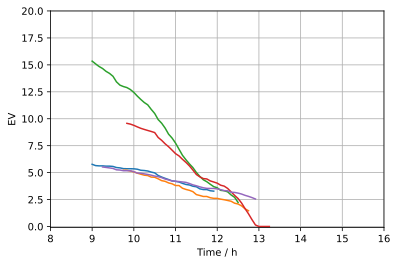

In [4]:
#plt.plot(observations[:-1,0],observations[:-1,4])
for i in range(5):
    plt.plot(observations[int(env.EVs_start[i]):int(env.EVs_end[i]),0],E_EV[int(env.EVs_start[i]):int(env.EVs_end[i]),i])
plt.ylim(-0.1,20)
plt.xlim(8,16)
plt.xlabel('Time / h')
plt.ylabel('EV')
plt.plot()
#plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

In [15]:
costs.sum()

117.92708418227255

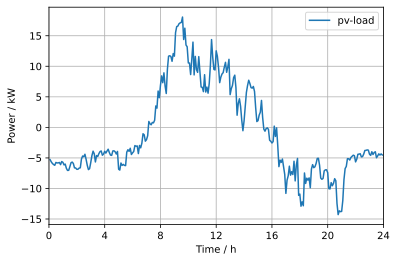

In [16]:
plt.plot(observations[:-1,0], observations[:-1,1], label='pv-load')
#plt.plot(x[:,0], x[:,2]-x[:,1]-x[:,3]-x[:,4]-x[:,5], label='Pbes')
#plt.ylim(0,100)
plt.xlim(0,24)
plt.xticks(np.linspace(0,24,7))
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/pv_load.svg',format='svg')
plt.show()

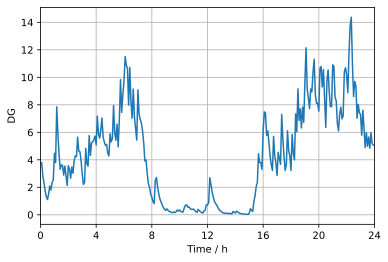

In [4]:
plt.plot(observations[:-1,0],observations[:-1,2])
#plt.ylim(0,1.05)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('DG')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

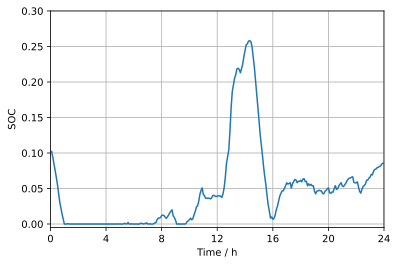

In [9]:
plt.plot(observations[:-1,0],observations[:-1,3])
plt.ylim(-0.005,0.3)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('SOC')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.savefig(fname='./figure/SOC_2.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [5]:
P_AC.sum()/12

45.40337479800777

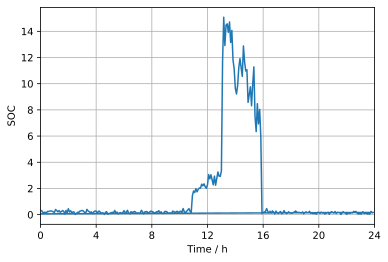

In [20]:
plt.plot(observations[:,0],P_AC.sum(axis=1))
#plt.ylim(0,1.05)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('SOC')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

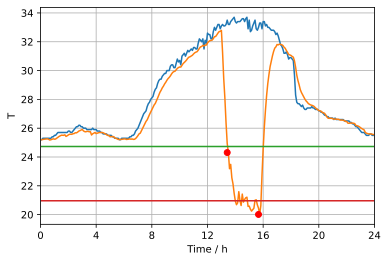

In [6]:
n=1
plt.plot(observations[:-1,0],observations[:-1,4])
plt.plot(observations[:-1,0],T_AC[:-1,n])
plt.plot(env.ACs_start[n]/12, T_AC[int(env.ACs_start[n]),n], 'ro')
plt.plot(env.ACs_end[n]/12, T_AC[int(env.ACs_end[n]),n], 'ro')
plt.plot(observations[:-1,0], env.ACs_parameter[3,n]*np.ones(12*24-1), label='Tmax')
plt.plot(observations[:-1,0], env.ACs_parameter[4,n]*np.ones(287), label='Tmin')
#plt.ylim(0,1.05)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('T')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

In [9]:
print(env.EVs_start) 
print(env.EVs_end)
print(env.EVs_required)

[107. 116. 107. 117. 110.]
[143. 153. 150. 159. 155.]
[ 5.80796534  5.34227791 15.65825758  9.57298177  5.54294039]


In [ ]:
import torch.distributions as dist
import numpy as np
from itertools import count
np.random.seed(1)
indoor = np.zeros([12*24,10])
EVs_demand = []
costs = []
GRU = []
MLP = []
actions = []
with torch.no_grad():
    obs = env.reset()
    hidden = None
    for episode_step in count():
        indoor[episode_step] = env.ACs_T
        obs_GRU = torch.from_numpy(obs_GRU.reshape(1,-1)).to(torch.float).to(device)
        obs_MLP = torch.from_numpy(obs_MLP.reshape(1,-1)).to(torch.float).to(device)
        mu, sigma, value, hidden = net(obs_GRU,obs_MLP,hidden)
        normal_probs = dist.normal.Normal(mu,sigma+1e-1)
        action = normal_probs.sample()
        action = action.detach().cpu().numpy()[0]
        obs_GRU, obs_MLP, cost, done, info = env.move(action)  
        # gather env data, reset done envs and update their obs
        if done==True:
            break
        
        EVs_demand.append(env.EVs_demand)
        GRU.append(obs_GRU)
        MLP.append(obs_MLP)
        actions.append(action)
        costs.append(cost)
GRU = np.array(GRU)
MLP = np.array(MLP)
costs = np.array(costs)

In [10]:
import torch 
dist = torch.distributions.Normal(torch.zeros(10),torch.ones(10))
action = dist.sample()
dist.log_prob(action)

tensor([-1.6962, -0.9419, -1.3281, -1.6329, -0.9218, -1.1649, -1.0231, -1.1641,
        -0.9214, -1.9878])